<a href="https://colab.research.google.com/github/lg960214/DACON_Seoul_6/blob/feat%2Fhhj/user_Top10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xlrd==1.2.0 #xls 읽기 위해

In [ ]:
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#xls 읽기 위해
!pip install xlrd==1.2.0 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [5]:
def read_df(y, m, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.
  for year in os.listdir(rootdir):
    sub_sub_dirs = {}
    for month in os.listdir(os.path.join(rootdir, year)):
      sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
    sub_dirs[int(year)] = sub_sub_dirs

  df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')

  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  return df

2022년 5월 기준
노인 승하차 데이터 5월까지 있음

#아침/저녁 전체이용 Top 10 (승하차)

In [ ]:
#시간대별 전체 승하차
df = read_df(2022, 5, 3)

time_dict = {'아침승차':['7시승차', '8시승차'], '아침하차':['7시하차', '8시하차'], '점심승차':['14시승차','15시승차'], '점심하차':['14시하차','15시하차'], '저녁승차':['18시승차', '19시승차'], '저녁하차':['18시하차', '19시하차']}
for s in ['아침승차', '아침하차', '점심승차', '점심하차', '저녁승차', '저녁하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

#아침승하차, 저녁승하차  
df2=df[['지하철역','아침승차','아침하차','저녁승차','저녁하차']]
df2['아침승하차']=df2['아침승차']+df2['아침하차']
df2['저녁승하차']=df2['저녁승차']+df2['저녁하차']

In [152]:
#아침승하차, 저녁승하차 합계만
df2 = df2.drop(columns=['아침승차', '아침하차', '저녁승차', '저녁하차'])

In [153]:
#아침승하차 순위
df2_am=(df2
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_am

,지하철역,아침승하차
0,가산디지털단지,443185.0
1,서울역,406143.0
2,선릉,405862.0
3,잠실(송파구청),393715.0
4,강남,385428.0
5,역삼,350411.5
6,구로디지털단지,347526.0
7,신림,318129.0
8,삼성(무역센터),306044.0
9,여의도,301804.0


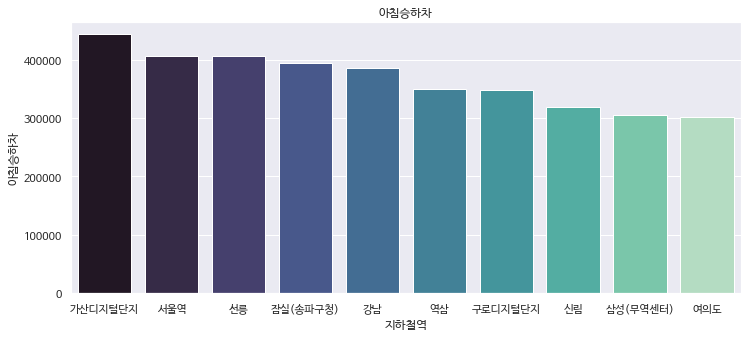

In [154]:
sns.set(rc={"figure.figsize":(12, 5)})
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=df2_am['지하철역'],y=df2_am['아침승하차'],palette="mako").set(title='아침승하차')
plt.show()

In [155]:
#저녁승하차 순위
df2_pm=(df2
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_pm

,지하철역,저녁승하차
0,잠실(송파구청),341402.5
1,홍대입구,320919.0
2,고속터미널,311084.5
3,강남,282314.0
4,서울역,247593.0
5,신림,243278.5
6,사당,242549.0
7,건대입구,218499.0
8,수원,195823.5
9,구로디지털단지,195707.0


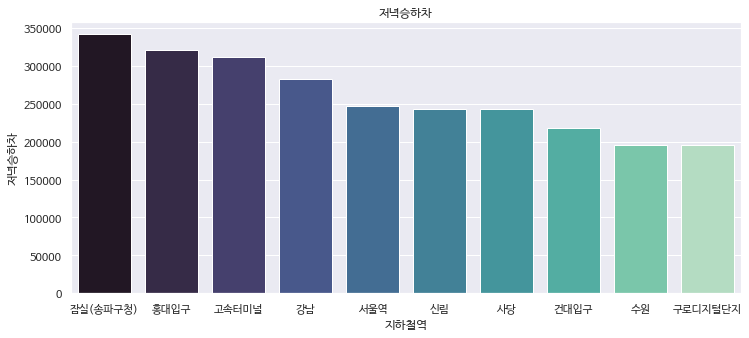

In [156]:
sns.set(rc={"figure.figsize":(12, 5)})
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=df2_pm['지하철역'],y=df2_pm['저녁승하차'],palette="mako").set(title='저녁승하차')
plt.show()

#아침/저녁 노인이용 Top10 (승하차)

In [ ]:
df3=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv',encoding='cp949')
df3.head()

In [162]:
#월단위로 추출하기 위해 date 타입으로 바꿔줌
df3['일자'] = pd.to_datetime(df3['일자'])

In [163]:
#5월 데이터 추출
query_month = 5 
filtered = df3.query('일자.dt.month == @query_month')

#아침승하차, 저녁승하차 합계
filtered =filtered[['역명','07시-08시','08시-09시','18시-19시','19시-20시']]
filtered= filtered.groupby(filtered['역명']).sum()
filtered['아침승하차']=filtered['07시-08시']+filtered['08시-09시']
filtered['저녁승하차']=filtered['18시-19시']+filtered['19시-20시']
filtered=filtered.drop(columns=['07시-08시','08시-09시','18시-19시','19시-20시'])


In [164]:
#노인 아침승하차
df3_am=(filtered
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .iloc[:10]
        )
df3_am

,아침승하차
역명,
연신내,38233.0
동대문,37379.0
신림,36004.0
사당,35874.0
서울역,35229.0
종로3가,34072.0
수유(강북구청),31136.0
고속터미널,30535.0
창동,30415.0


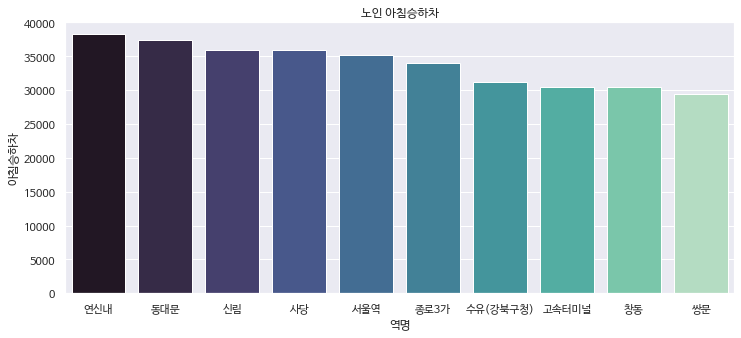

In [165]:
sns.set(rc={"figure.figsize":(12, 5)})
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=df3_am.index,y=df3_am['아침승하차'],palette="mako").set(title='노인 아침승하차')
plt.show()

In [166]:
#노인 저녁승하차
df3_pm=(filtered
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .iloc[:10]
        )
df3_pm

,저녁승하차
역명,
종로3가,72574.0
사당,49054.0
고속터미널,41995.0
잠실(송파구청),41047.0
연신내,40644.0
신림,37362.0
천호(풍납토성),36175.0
창동,35336.0
청량리(서울시립대입구),34883.0


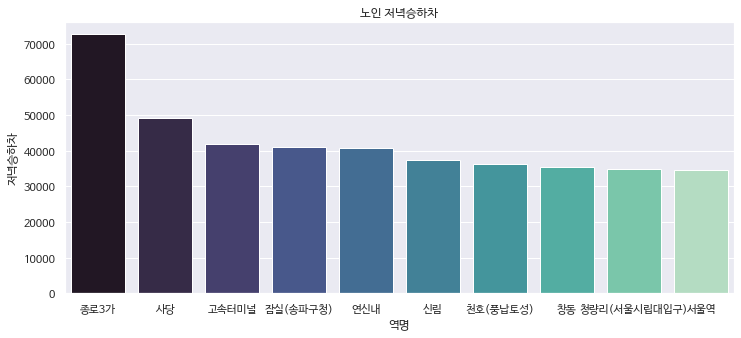

In [167]:
sns.set(rc={"figure.figsize":(12, 5)})
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=df3_pm.index,y=df3_pm['저녁승하차'],palette="mako").set(title='노인 저녁승하차')
plt.show()

#우대권 사용 Top10

In [ ]:
df4=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_권종별 승차인원_20220531.csv',encoding='cp949')
df4.head()

In [177]:
df4=(df4[['역명','5월우대권']]
    .sort_values('5월우대권',ascending=False)
    .reset_index(drop=True)
    .iloc[:10]
    )
df4

,역명,5월우대권
0,종로3가(1),311427
1,제기동,278052
2,종로5가,264996
3,청량리,263148
4,연신내(3),261815
5,신림,230226
6,서울역(1),205682
7,선릉,205212
8,사당(2),203533
9,회현,203335


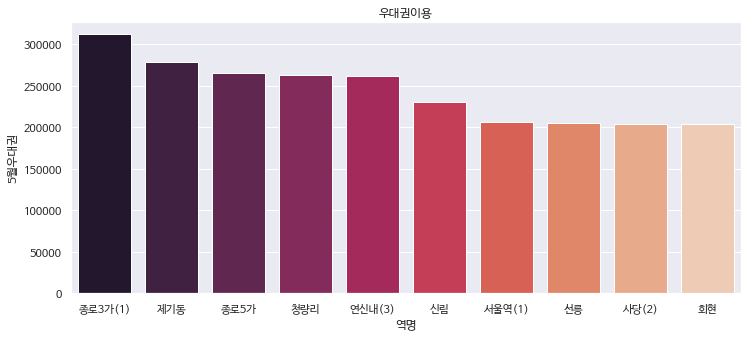

In [191]:
sns.set(rc={"figure.figsize":(12, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("rocket",n_colors=10)
# palette.reverse() 
sns.barplot(x=df4['역명'],y=df4['5월우대권'],palette=palette).set(title='우대권이용')
plt.show()